<a href="https://colab.research.google.com/github/taewonkim2/googleCloud/blob/main/etf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [1]:
import numpy as np
import pandas as pd
import os
import re
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumBarunGothic')
sns.set(font='NanumBarunGothic')
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
def etftoday(date = None):
  # 날짜 입력값 조정
  if date is None:
    date = datetime.now().strftime('%Y%m%d')
  else : date = str(date)

  # 폴더존재여부 확인 및 함수 계속 진행여부 결정
  path = '/content/drive/MyDrive/1. Study/0. My정리파일/★ Two Job/ETF사이트 구축/etf/'+ date
  if not os.path.exists(path):
    print("해당날짜의 데이터(폴더)가 존재하지 않습니다.")
    return

  # 시세데이터의 파일명 바꾸기
  fileList = os.listdir(path)
  patternBefore = r'^data_\d{4}_20\d{6}\.csv$'
  patternAfter = r'^data_20\d{6}\.csv$'        #^data_20\d{6}\.csv$

  fileNm = next((x for x in fileList if re.match(patternBefore, x)),None)
  # 설정한 형태의 파일이 있으면 지정된 형식으로 변경
  if fileNm != None:
    sise = fileNm.split('_')[0]+'_'+fileNm.split('_')[2]
    os.rename(os.path.join(path,fileNm),os.path.join(path,sise))
  # 이미 변경된 파일명의 형태로 존재 시 그대로 사용
  elif next((x for x in fileList if re.match(patternAfter, x)),None) != None:
    sise = next((x for x in fileList if re.match(patternAfter, x)),None)
  elif next((x for x in fileList if 'data_' in x),None) == None:
    print("해당날짜의 시세파일이 존재하지 않아 그래프를 그릴 수 없습니다.")
    return

  # 파일 읽어오기
  csv  = ['상품검색.csv', '수익률 및 총보수(일별).csv', '추적오차 및 괴리율(일별).csv', '자산규모 및 유동성(일별).csv', '투자위험(기간).csv',sise,'etf_basic.csv']
  file = ['search','profitFee','tracking','asset','risk','sise','basic']

  for i in zip(file,csv):
    globals()[i[0]] = pd.read_csv(os.path.join(path,i[1]),encoding = 'euc-kr')
    if i[0] == 'asset':
      globals()[i[0]] = globals()[i[0]].drop(columns = '순자산총액')
      globals()[i[0]]['종목코드'] = globals()[i[0]]['종목코드'].astype('str').str.zfill(6)
    elif i[0] == 'basic':
      globals()[i[0]]['단축코드'] = globals()[i[0]]['단축코드'].astype('str').str.zfill(6)
    else:
      globals()[i[0]]['종목코드'] = globals()[i[0]]['종목코드'].astype('str').str.zfill(6)

  # 불필요한 파일 삭제
  removeList = list(set(fileList).difference(set(csv)))
  for name in removeList:
    removefile = os.path.join(path,name)
    if os.path.exists(removefile):
      os.remove(removefile)

  # 전체파일을 하나로 Merge하고 중복되는 column을 삭제
  var = [globals()[x] for x in file]
  # from functools import reduce의 좋은 샘플임. 꼭 참고할 것 : merged = reduce(lambda left,right : pd.merge(left,right,on = '종목명',how = 'inner'),var)
  merged = var[0].copy()
  for df in var[1:-1]:
    merged = merged.merge(df,on = '종목코드',how = 'inner')
    colY = [x for x in merged.columns if '_y' in x]
    merged = merged.drop(columns = colY)

    colX = [x for x in merged.columns if '_x' in x]
    col_rename = {col: col.replace('_x', '') for col in colX}
    merged = merged.rename(columns=col_rename)

  merged = merged.merge(basic[['단축코드','기초시장분류','지수산출기관','추적배수']],left_on = '종목코드', right_on = '단축코드',how = 'inner').drop('단축코드',axis = 1).rename(columns = {'기초시장분류':'국내/해외'})
  merged['추적배수'] = merged['추적배수'].apply(lambda x: 1 if x == '일반' else (2 if x == '2X 레버리지' else (-2 if x == '2X 인버스' else -1)))
  merged = merged.drop(columns = ['수익률','수익률(최근 1년)','외국인보유비중'])

  # etf_기본정보에서 국내/해외 구분 및 산출기관 정보 가져와서 merge
  # basic = pd.read_csv(os.path.join(path,'etf_basic.csv'),encoding = 'euc-kr')
  # basic['단축코드'] = basic['단축코드'].astype('str').str.zfill(6)
  # merged = merged.merge(basic[['단축코드','기초시장분류','지수산출기관','추적배수']],left_on = '종목코드', right_on = '단축코드',how = 'inner').drop('단축코드',axis = 1).rename(columns = {'기초시장분류':'국내/해외'})
  # lambda 함수를 사용하여 '추적배수' 컬럼 값 변경
  # merged['추적배수'] = merged['추적배수'].apply(lambda x: 1 if x == '일반' else (2 if x == '2X 레버리지' else (-2 if x == '2X 인버스' else -1)))

  # merged = merged.drop(columns = ['수익률','수익률(최근 1년)','외국인보유비중'])

  # 분류체계 필드 split
  gubun = merged['분류체계'].str.split('-',expand = True)
  gubun = gubun.rename(columns = {0:'상품',1:'분류_1',2:'분류_2'})
  merged = pd.concat([merged,gubun],axis = 1).drop('분류체계',axis =1)

  # 가로기준으로 apply를 적용하는 매우 좋은 샘플
  merged['분류_1'] = merged.apply(lambda row: row['상품'] if pd.isnull(row['분류_1']) else row['분류_1'], axis=1)
  merged['분류_2'] = merged.apply(lambda row: row['분류_1'] if pd.isnull(row['분류_2']) else row['분류_2'], axis=1)

  # 분류_1 == 혼합자산 -> 주식/채권으로 상품, 분류_1,분류_2를 수정
  merged['상품']   = merged['상품'].apply(lambda x :'주식+채권' if x == '혼합자산' else x )
  merged['분류_1'] = merged['분류_1'].apply(lambda x :'주식+채권' if x == '혼합자산' else x )
  merged['분류_2'] = merged['분류_2'].apply(lambda x :'주식+채권' if x == '혼합자산' else x )

  # 분류_1이 '업종섹터'이며 '분류_2'가 None인 경우 '분류_2를 업종테마'로 표시
  merged['분류_2'] = merged.apply(lambda row : '업종테마' if row['분류_1'] == '업종섹터' else row['분류_2'],axis = 1)

  # 분류_1 == 혼합 -> 채권혼합으로 분류_1,분류_2를 수정
  merged['분류_1'] = merged['분류_1'].apply(lambda x :'채권혼합' if x == '혼합' else x )
  # merged['분류_2'] = merged['분류_2'].apply(lambda x :'채권혼합' if x == '혼합' else x )
  merged['분류_2'] = merged.apply(lambda row: '채권혼합' if row['상품'] == '채권혼합' and row['분류_1'] == '채권혼합' else row['분류_2'], axis=1)
  # 상품 == 원자재이고 분류_2가 '혼합'인 경우 '분류_1'+혼합으로 대체
  merged['분류_2'] = merged.apply(lambda row: row['분류_1']+'혼합' if row['상품'] == '원자재' and row['분류_2'] == '혼합' else row['분류_2'], axis=1)
  # 분류_1 == 규모 -> 주식/규모별로 분류_1을 수정
  merged['분류_1'] = merged['분류_1'].apply(lambda x :'주식/규모별' if x == '규모' else x )
  # 분류_1 == 부동산 -> 리츠로 분류_1,분류_2를 수정
  merged['분류_1'] = merged['분류_1'].apply(lambda x :'리츠' if x == '부동산' else x )
  merged['분류_2'] = merged['분류_2'].apply(lambda x :'리츠' if x == '부동산' else x )
  # 상품 == 주식 or 채권인 경우 분류_1을 하나 더 만들어 '분류_1_주식채권'으로 설정
  merged['분류_1_주식채권'] = merged['분류_1'].copy()
  # merged['분류_1'] = merged.apply(lambda row : row['상품'] if row['상품'] == '주식' else ( row['상품'] if row['상품']=='채권' else row['분류_1']),axis = 1)
  merged['분류_1'] = merged.apply(lambda row : row['상품'] if row['상품'] == '주식' else row['분류_1'],axis = 1)
  # 중첩되는 column삭제 ( 기초지수, 기초지수_지수명)
  merged = merged.drop(columns = '기초지수')
  return merged

In [3]:
etf_today = etftoday(20250703)

In [4]:
etf_today.head()

,종목코드,종목명,상장일,운용사,추적오차,순자산총액,괴리율,변동성,복제방법,총보수,과세유형,수익률_1D,수익률_1M,수익률_3M,수익률_6M,수익률_1Y,수익률_3Y,수익률_5Y,장중 괴리율,3개월 괴리율_평균 괴리율,3개월 괴리율_최소 괴리율,3개월 괴리율_최대 괴리율,거래대금_1D,평균거래대금_3M,평균거래대금_6M,평균거래대금_9M,평균거래대금_1Y,거래량_1D,평균거래량_3M,평균거래량_6M,평균거래량_9M,평균거래량_1Y,종가,대비,등락률,순자산가치(NAV),시가,고가,저가,거래량,거래대금,시가총액,상장좌수,기초지수_지수명,기초지수_종가,기초지수_대비,기초지수_등락률,국내/해외,지수산출기관,추적배수,상품,분류_1,분류_2,분류_1_주식채권
0,466400,1Q 25-08 회사채(A+이상)액티브,2023/09/19,하나자산운용,0.06,113497629776,0.01,매우낮음,실물(액티브),0.10,배당소득세(보유기간과세),0.01,0.22,0.78,1.74,3.69,0.0,0.0,0.01,0.01,-0.01,0.05,28321140,105676171,158259424,150655508,165207569,260,973,1466,1401,1546,108955,20,0.02,108949.35,108950,108960,108950,142,15471575,113531110000,1042000,KIS 2025-08만기형 크레딧 A+이상 지수(총수익),123.16,0.00,0.00,국내,KIS자산평가,1,채권,회사채,단기,회사채
1,491610,1Q CD금리액티브(합성),2024/09/24,하나자산운용,0.06,280822525557,0.01,매우낮음,합성(액티브),0.02,배당소득세(보유기간과세),0.01,0.21,0.67,1.40,0.00,0.0,0.0,-0.05,0.01,NaN,0.04,268144500,357537611,370689177,317542088,310692133,2619,3503,3645,3129,3062,102405,20,0.02,102454.57,102405,102410,102405,1546,158324149,280896915000,2743000,KIS 하나 CD금리 총수익지수,11499.57,0.00,0.00,국내,KIS자산평가,1,기타,기타,기타,기타
2,451060,1Q K200액티브,2023/01/31,하나자산운용,0.89,137612046074,-0.08,높음,실물(액티브),0.18,배당소득세(보유기간과세),-0.37,15.41,23.61,32.48,11.22,0.0,0.0,0.01,-0.21,-0.73,0.11,598435625,480719007,369568467,307257785,307759053,44595,40611,32154,27184,27047,13650,170,1.26,13649.02,13640,13675,13530,16587,225692960,139230000000,10200000,코스피 200,419.39,4.96,1.20,국내,KRX,1,주식,주식,시장대표,시장대표
3,463290,1Q 단기금융채액티브,2023/08/03,하나자산운용,0.05,170024965158,0.00,매우낮음,실물(액티브),0.08,배당소득세(보유기간과세),0.01,0.21,0.76,1.66,3.53,0.0,0.0,0.00,0.00,-0.01,0.02,248145355,1359677802,1185302451,1235013689,1511163975,2303,12665,11075,11599,14292,107770,25,0.02,107765.52,107795,107795,107760,1916,206478180,170061060000,1578000,MK 머니마켓 지수(총수익),14320.11,1.01,0.01,국내,KIS자산평가,1,채권,채권혼합,단기,채권혼합
4,479080,1Q 머니마켓액티브,2024/04/02,하나자산운용,0.05,565674766264,0.01,매우낮음,실물(액티브),0.05,배당소득세(보유기간과세),0.01,0.22,0.78,1.65,3.60,0.0,0.0,0.01,0.01,-0.01,0.03,6321155130,6079683253,4372123711,3553659494,3250218191,120677,116477,83952,68428,62838,52390,5,0.01,52391.70,52385,52395,52385,37668,1973511680,565812000000,10800000,KIS-하나 MMF 지수(총수익),116.95,0.00,0.00,국내,KIS자산평가,1,채권,채권혼합,단기,채권혼합


In [5]:
# 그냥 참고소스임. 진행과 무관함
path = '/content/drive/MyDrive/★ Two Job/ETF사이트 구축/etf/20240329'+'/'+'추적오차 및 괴리율(일별).csv'
etf = pd.read_csv(path,encoding = 'euc-kr')
etf_분류 = etf['분류체계'].str.split('-',expand = True).rename(columns ={0:'상품',1:'분류_1',2:'분류_2'})
etf_con = pd.concat([etf,etf_분류],axis = 1)
etf_con.query("분류_1 == '국공채' and 분류_2.isnull()").head()
# etf_con.query("분류_1 == '업종섹터'&분류_2.isnull()")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/★ Two Job/ETF사이트 구축/etf/20240329/추적오차 및 괴리율(일별).csv'

In [6]:
etf_today.pivot_table(index = ['상품','분류_1','분류_2'],aggfunc = {'등락률':'mean','종목코드':'size'},values = ['등락률','종목코드'])

등락률  종목코드
상품    분류_1  분류_2                 
기타    기타    기타     0.149259    27
부동산   리츠    리츠     0.225455    11
원자재   금속    구리     0.810000     2
            금      0.425556     9
            금속혼합   0.580000     2
            은      1.190000     1
            팔라듐   -0.110000     2
      농산물   농산물혼합  1.575000     2
            콩      1.820000     1
      에너지   원유    -0.057500     4
주식    주식    가치     0.896667     9
            구조화    0.655172    29
            기업그룹   1.170000    12
            대형주    1.070000     9
            배당     0.664595    37
            변동성    0.270000     3
            성장     0.128000     5
            시장대표   0.640133   226
            업종테마   1.165559   313
            전략테마   0.898182    55
            중형주    0.154000     5
            혼합/퀀트  0.465000     4
주식+채권 주식+채권 주식+채권  0.228929    56
채권    국공채   국공채    0.280000     1
            단기     0.032857    14
            장기    -0.009362    47
            중기     0.048000    15
      채권혼합  단기     0.027692    26
            장기     0.070000     1
            중기     0.087857    14
            혼합    -0.010000     3
      회사채   단기     0.050455    22
            장기     0.250000     1
            중기     0.102500     8
            회사채    0.133333     3
통화    미국달러  미국달러   0.006364    11
      일본엔   일본엔    0.000000     1

### "상품"별 당일수익률 시각화

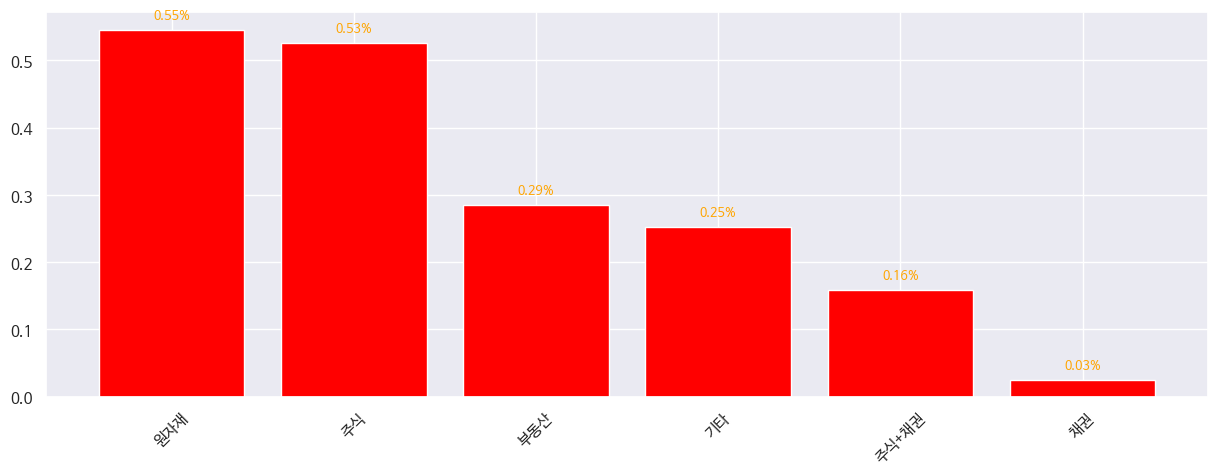

In [7]:
gubun = '상품'
period = '등락률'
market = '해외'        # 국내, 해외, 국내&해외
product = etf_today.query("`국내/해외` == @market").pivot_table(index = gubun,values = period,aggfunc = 'mean')
data = product.sort_values(by=period, ascending=False)

plt.figure(figsize=(15, 5))
# 색상 결정
colors = ['red' if x > 0 else 'blue' for x in data[period]]

# 막대 그래프 그리기
bars = plt.bar(data.index, data[period], color=colors)

# 값 표시 및 위치 조정
for bar in bars:
    height = bar.get_height()
    # 값이 0보다 크면 텍스트를 막대 아래에, 0 이하면 막대 위에 표시
    va_position = 'bottom' if height > 0 else 'top'
    # 텍스트 위치 조정을 위한 높이 조정: 값이 양수일 때와 음수일 때 각각 다르게 적용
    text_position = height + 0.01 if height > 0 else height - 0.01
    plt.text(bar.get_x() + bar.get_width() / 2.0, text_position, f'{height:.2f}%', ha='center', va=va_position, color= 'orange' if height>=0 else 'black', fontsize = 9)

plt.xticks(rotation=45)
plt.show()

### '기타'전체 종목 수익률 차트

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


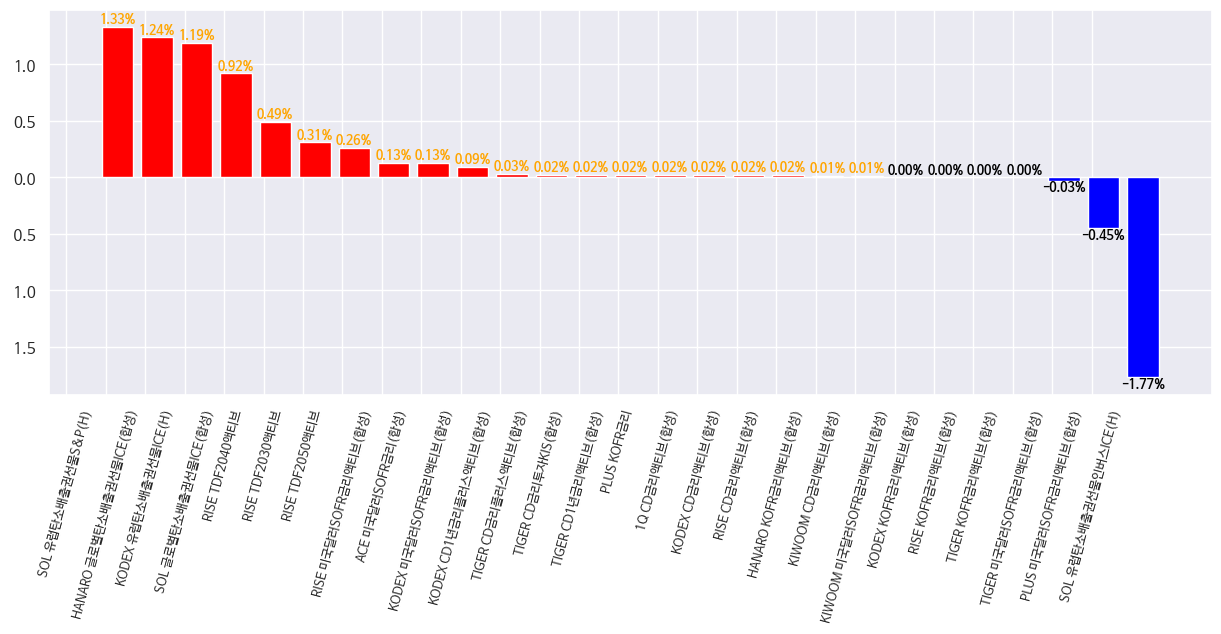

In [12]:
product = '기타'
code = etf_today.query("상품 == @product").sort_values(by = '등락률',ascending = False)
plt.figure(figsize=(15, 5))
colors = ['red' if x > 0 else 'blue' for x in code['등락률']]
bars = plt.bar(code['종목명'],code['등락률'],color = colors)

for bar in bars:
  height = bar.get_height()
  va_position = 'bottom' if height >= 0 else 'top'
  text_position = height + 0.001 if height > 0 else height - 0.001
  plt.text(bar.get_x()+bar.get_width()/2,text_position, f'{height:.2f}%',ha = 'center',
           va = va_position,color = 'orange' if height>0 else 'black',weight = 'bold',fontsize = 9)

plt.xticks(rotation=75)
plt.xticks([i - 1.3 for i in range(len(code['종목명']))], code['종목명'],fontsize = 9)
plt.show()

### '부동산'전체 종목 수익률 차트

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


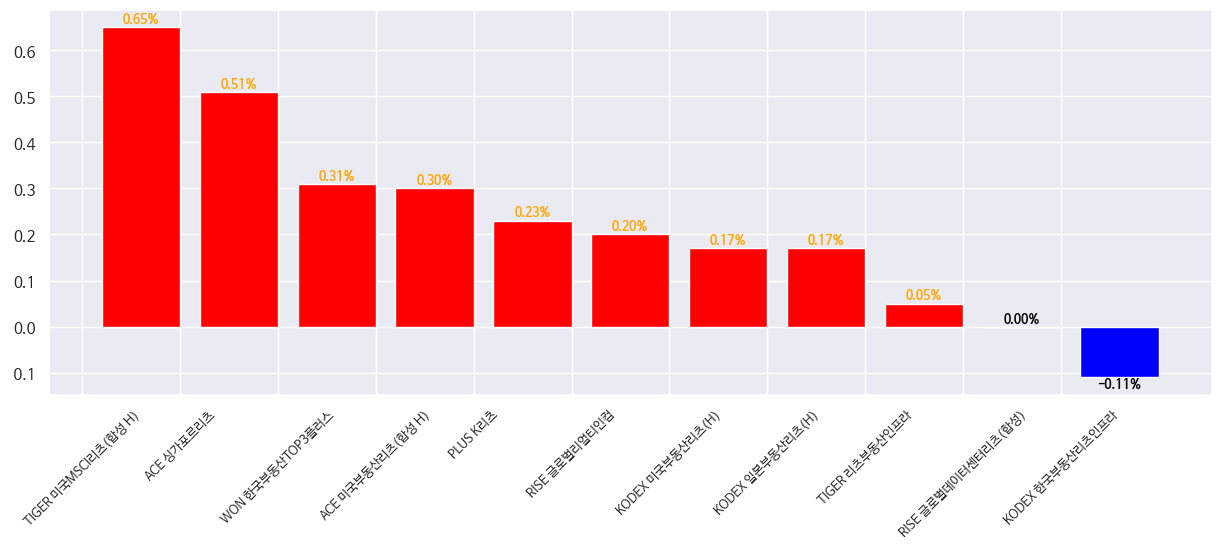

In [13]:
product = '부동산'
code = etf_today.query("상품 == @product").sort_values(by = '등락률',ascending = False)
plt.figure(figsize=(15, 5))
colors = ['red' if x > 0 else 'blue' for x in code['등락률']]
bars = plt.bar(code['종목명'],code['등락률'],color = colors)

for bar in bars:
  height = bar.get_height()
  va_position = 'bottom' if height >= 0 else 'top'
  text_position = height + 0.001 if height > 0 else height - 0.001
  plt.text(bar.get_x()+bar.get_width()/2,text_position, f'{height:.2f}%',ha = 'center',va = va_position,color = 'orange' if height>0 else 'black',weight = 'bold',fontsize = 9)

plt.xticks(rotation=45)
plt.xticks([i - 0.6 for i in range(len(code['종목명']))], code['종목명'],fontsize = 9)
plt.show()

### '주식+채권'전체 종목 수익률 차트 -> 개별상품별로 다른 자산분류로 재분류 필요(분류_1, 분류_2에 다시 기재)

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


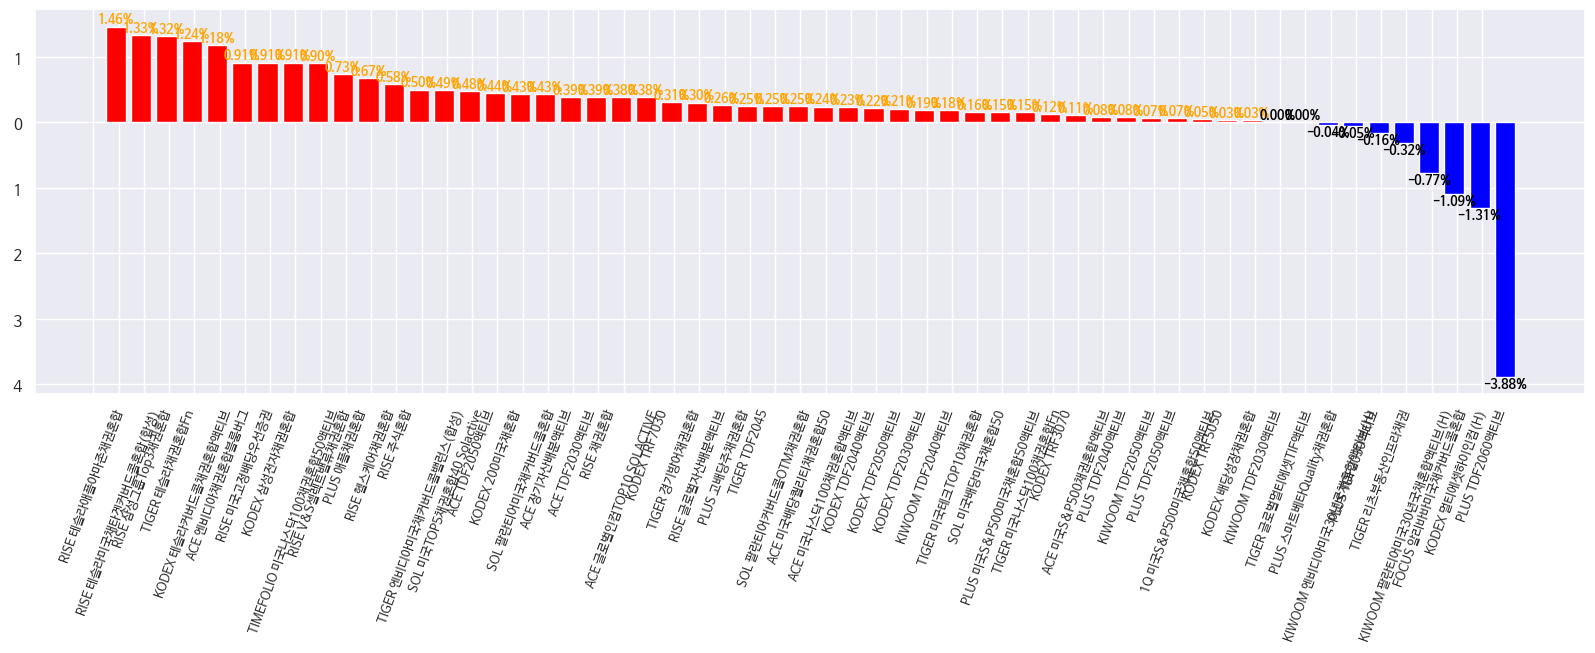

In [14]:
product = '주식+채권'
code = etf_today.query("상품 == @product").sort_values(by = '등락률',ascending = False)
plt.figure(figsize=(20, 5))
colors = ['red' if x > 0 else 'blue' for x in code['등락률']]
bars = plt.bar(code['종목명'],code['등락률'],color = colors)

for bar in bars:
  height = bar.get_height()
  va_position = 'bottom' if height >= 0 else 'top'
  text_position = height + 0.001 if height > 0 else height - 0.001
  plt.text(bar.get_x()+bar.get_width()/2,text_position, f'{height:.2f}%',ha = 'center',va = va_position,color = 'orange' if height>0 else 'black',weight = 'bold',fontsize = 9)

plt.xticks(rotation=70)
plt.xticks([i - 0.9 for i in range(len(code['종목명']))], code['종목명'],fontsize = 9)
plt.show()

In [15]:
product = '주식+채권'
code = etf_today.query("상품 == @product").sort_values(by = '등락률',ascending = False)
code['종목명'].str.split(' ',expand = True)

,0,1,2
650,RISE,테슬라애플아마존채권혼합,None
649,RISE,테슬라미국채타겟커버드콜혼합(합성),None
622,RISE,삼성그룹Top3채권혼합,None
923,TIGER,테슬라채권혼합Fn,None
443,KODEX,테슬라커버드콜채권혼합액티브,None
84,ACE,엔비디아채권혼합블룸버그,None
601,RISE,미국고정배당우선증권,None
389,KODEX,삼성전자채권혼합,None
942,TIMEFOLIO,미국나스닥100채권혼합50액티브,None
560,RISE,V&S셀렉트밸류채권혼합,None


### '통화'전체 종목 수익률 차트

/tmp/ipython-input-16-1474213162.py:16: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


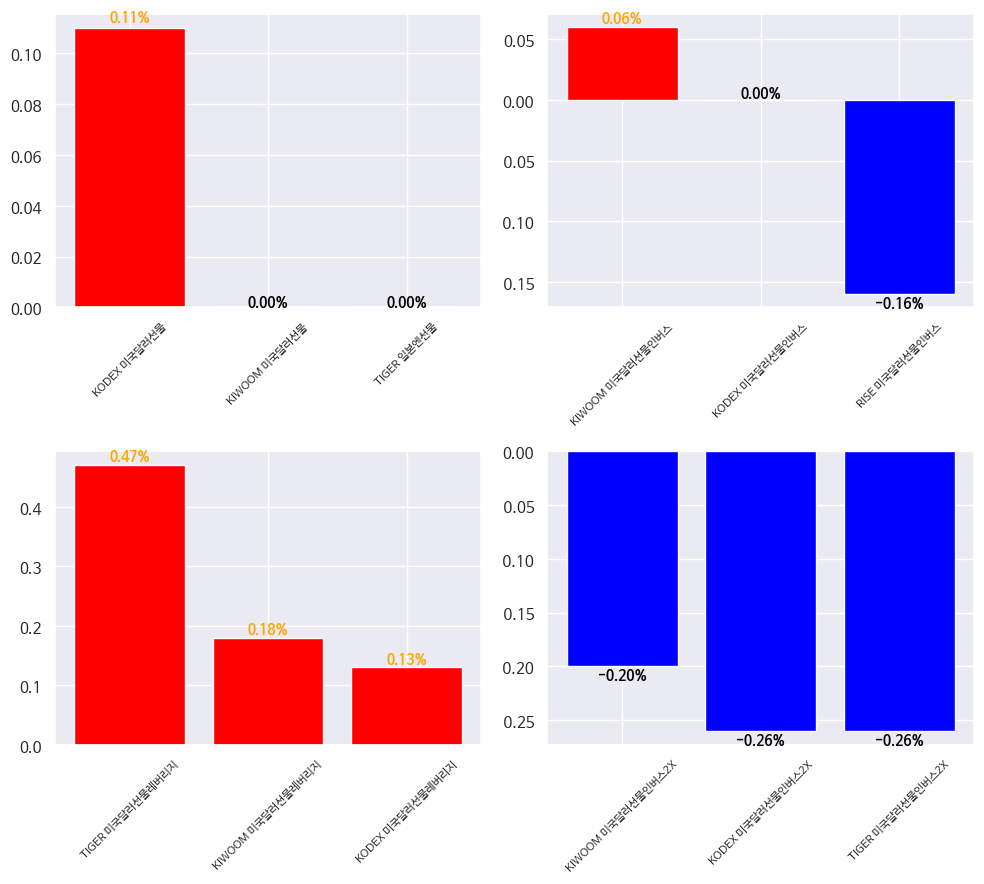

In [16]:
fig,ax = plt.subplots(figsize = (10,9),nrows = 2, ncols = 2)
product = '통화'
for i, j in zip([1, -1, 2, -2], [0, 1, 2, 3]):
    code = etf_today.query("상품 == @product and 추적배수 == @i").sort_values(by='등락률', ascending=False)
    row, col = divmod(j, 2)
    colors = ['red' if x > 0 else 'blue' for x in code['등락률']]
    bars = ax[row][col].bar(code['종목명'], code['등락률'], color=colors)
    for bar in bars:
        height = bar.get_height()
        va_position = 'bottom' if height >= 0 else 'top'
        text_position = height + 0.001 if height > 0 else height - 0.001
        ax[row][col].text(bar.get_x() + bar.get_width() / 2, text_position, f'{height:.2f}%', ha='center',va=va_position, color='orange' if height > 0 else 'black', weight='bold', fontsize=10)
    # 축에 대한 눈금 설정
    ax[row][col].set_xticks(ax[row][col].get_xticks())
    ax[row][col].tick_params(axis='x', rotation=45,labelsize = 8)  # 눈금 라벨 회전 설정
plt.tight_layout()
plt.show()

### '채권'전체 종목 수익률 차트

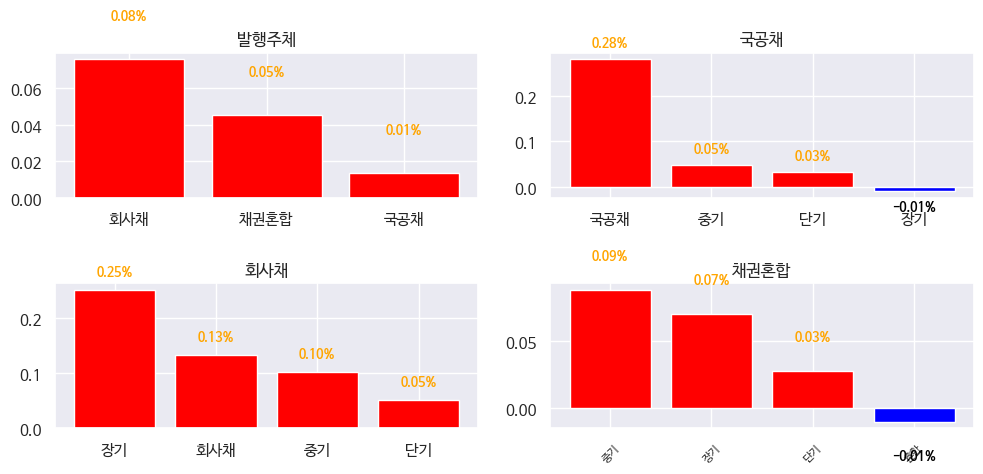

In [17]:
fig = plt.figure(figsize = (10,5))
for i,name in enumerate(['채권','국공채','회사채','채권혼합']):
  if i == 0:
    globals()['bond_'+str(i+1)] = etf_today.query("상품 =='채권'").pivot_table(index = '분류_1', values = '등락률', aggfunc = 'mean').sort_values(by='등락률', ascending=False)
  else:
     globals()['bond_'+str(i+1)] = etf_today.query("상품 =='채권' and 분류_1 == @name").pivot_table(index = '분류_2', values = '등락률', aggfunc = 'mean').sort_values(by='등락률', ascending=False)

for i in range(4):
  globals()['ax'+str(i+1)] = fig.add_subplot(2,2,i+1)
  title = ['발행주체', '국공채','회사채','채권혼합']
  chart = globals()['ax'+str(i+1)]
  bond = globals()['bond_'+str(i+1)]
  colors = ['red' if x >= 0 else 'blue' for x in bond['등락률']]
  bars = chart.bar(bond.index, bond['등락률'],color = colors)
  chart.set_title(title[i])
  for bar in bars:
    height = bar.get_height()
    va_position = 'bottom' if height >=0 else 'top'
    text_position =  height + 0.02 if height >=0 else height - 0.02
    chart.text(bar.get_x()+bar.get_width()/2,text_position,f'{height:.2f}%',ha = 'center',va =  va_position, color='orange' if height > 0 else 'black', weight='bold', fontsize=9)
    # 축에 대한 눈금 설정
# ax1.set_xticks(ax1.get_xticks(),rotation = 45, labelsize = 8)
chart.tick_params(axis='x', rotation=45,labelsize = 8)  # 눈금 라벨 회전 설정
plt.tight_layout()
plt.show()

### '원자재'전체 종목 수익률 차트

/tmp/ipython-input-18-1989101151.py:22: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) NanumBarunGothic.
  fig.canvas.print_figure(bytes_io, **kw)


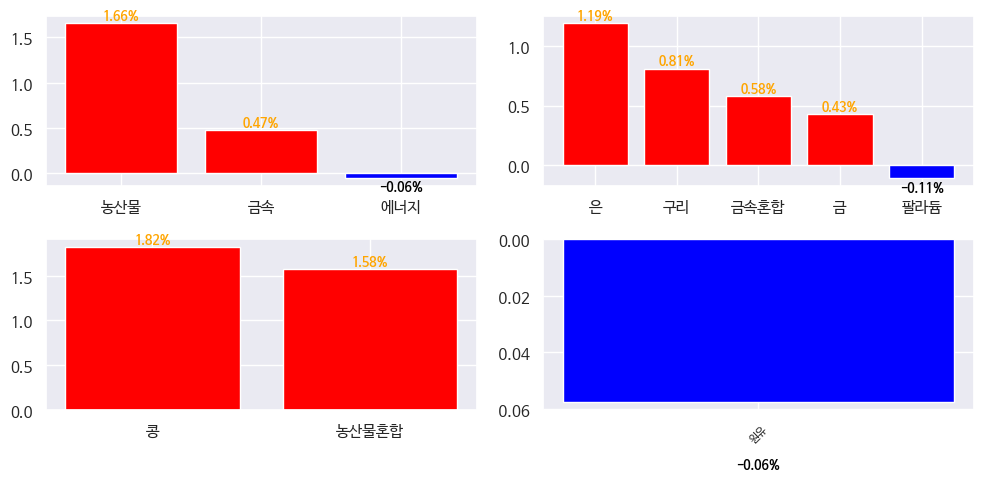

In [18]:
fig = plt.figure(figsize = (10,5))
for i,name in enumerate(['원자재','금속','농산물','에너지']):
  if i == 0:
    globals()['bond_'+str(i+1)] = etf_today.query("상품 ==@name").pivot_table(index = '분류_1', values = '등락률', aggfunc = 'mean').sort_values(by='등락률', ascending=False)
  else:
     globals()['bond_'+str(i+1)] = etf_today.query("상품 =='원자재' and 분류_1 == @name").pivot_table(index = '분류_2', values = '등락률', aggfunc = 'mean').sort_values(by='등락률', ascending=False)

for i in range(4):
  globals()['ax'+str(i+1)] = fig.add_subplot(2,2,i+1)
  chart = globals()['ax'+str(i+1)]
  bond = globals()['bond_'+str(i+1)]
  colors = ['red' if x >= 0 else 'blue' for x in bond['등락률']]
  bars = chart.bar(bond.index, bond['등락률'],color = colors)
  for bar in bars:
    height = bar.get_height()
    va_position = 'bottom' if height >=0 else 'top'
    text_position =  height + 0.002 if height >=0 else height - 0.02
    chart.text(bar.get_x()+bar.get_width()/2,text_position,f'{height:.2f}%',ha = 'center',va =  va_position, color='orange' if height > 0 else 'black', weight='bold', fontsize=9)
    # 축에 대한 눈금 설정
# ax1.set_xticks(ax1.get_xticks(),rotation = 45, labelsize = 8)
chart.tick_params(axis='x', rotation=45,labelsize = 8)  # 눈금 라벨 회전 설정
plt.tight_layout()
plt.show()

### '국내/해외'별 당일수익률 시각화

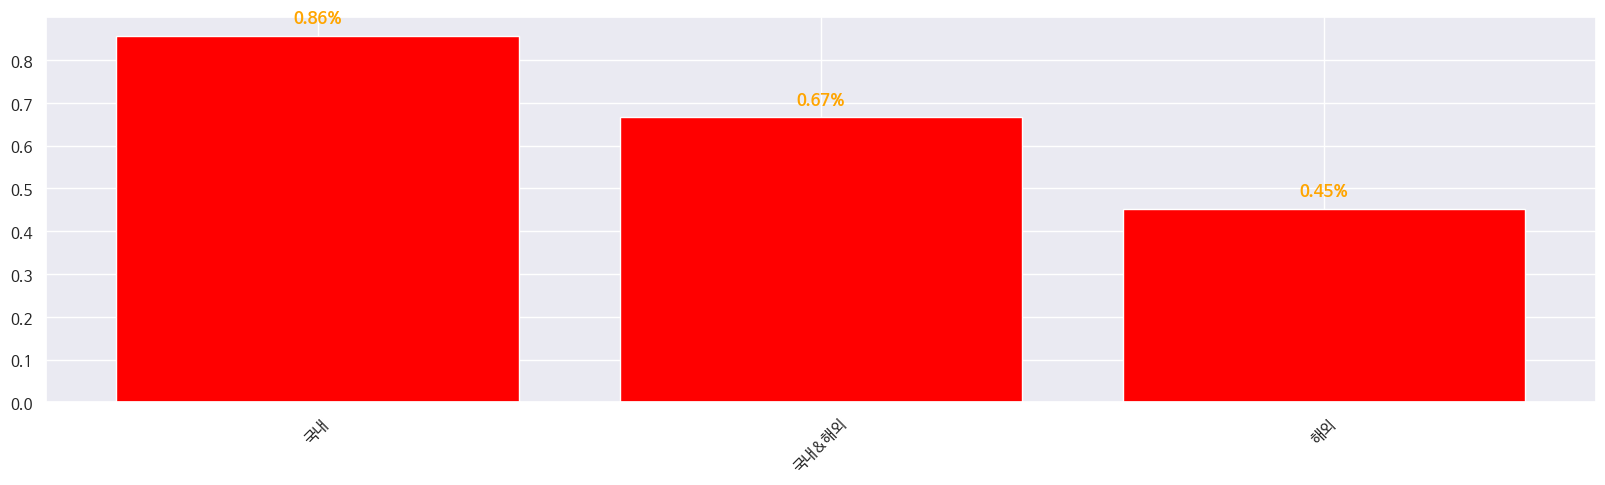

In [19]:
gubun = '국내/해외'
period = '등락률'
product = etf_today.pivot_table(index=gubun, values=period, aggfunc='mean')
data = product.sort_values(by=period, ascending=False)

plt.figure(figsize=(20, 5))
# 색상 결정
colors = ['red' if x > 0 else 'blue' for x in data[period]]

# 막대 그래프 그리기
bars = plt.bar(data.index, data[period], color=colors)

# 값 표시 및 위치 조정
for bar in bars:
    height = bar.get_height()
    # 값이 0보다 크면 텍스트를 막대 아래에, 0 이하면 막대 위에 표시
    va_position = 'bottom' if height > 0 else 'top'
    # 텍스트 위치 조정을 위한 높이 조정: 값이 양수일 때와 음수일 때 각각 다르게 적용
    text_position = height + 0.02 if height > 0 else height - 0.02
    plt.text(bar.get_x() + bar.get_width() / 2.0, text_position, f'{height:.2f}%', ha='center', va=va_position, color='orange' if height > 0 else 'black', fontsize=12, weight =  'bold')

plt.xticks(rotation=45)
plt.show()